# Objective
Build a model that accurately predicts telecom customer churn to help the company identify churning customers and improve retention strategies.

In [43]:
# import all necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import optuna

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load dataset
df = pd.read_csv("mydata.csv")

## Data Understanding

In [ ]:
# check top 5 rows of dataset
df.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,22.0,Female,25.0,14.0,4.0,27.0,Basic,Monthly,598.0,9.0,1.0
1,41.0,Female,28.0,28.0,7.0,13.0,Standard,Monthly,584.0,20.0,0.0
2,47.0,Male,27.0,10.0,2.0,29.0,Premium,Annual,757.0,21.0,0.0
3,35.0,Male,9.0,12.0,5.0,17.0,Premium,Quarterly,232.0,18.0,0.0
4,53.0,Female,58.0,24.0,9.0,2.0,Standard,Annual,533.0,18.0,0.0


CustomerID feature is not useful.

In [ ]:
# check shape of dataset
df.shape

(505207, 12)

Dataset have 12 columns and 505207 row samples.

In [ ]:
# check how much null values dataset have
df.isnull().sum()

,0
CustomerID,1
Age,1
Gender,1
Tenure,1
Usage Frequency,1
Support Calls,1
Payment Delay,1
Subscription Type,1
Contract Length,1
Total Spend,1


All columns have 1 null value.

In [ ]:
# check how much duplicate row samples dataset have
df.duplicated().sum()

np.int64(0)

Dataset don't have any duplicate row sample

In [ ]:
# check datatype of each column
df.dtypes

,0
CustomerID,float64
Age,float64
Gender,object
Tenure,float64
Usage Frequency,float64
Support Calls,float64
Payment Delay,float64
Subscription Type,object
Contract Length,object
Total Spend,float64


In [ ]:
# describe function on dataset
df.describe()

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000
mean,200779.451782,39.704172,31.350435,15.714825,3.833317,13.496843,620.072766,14.610581,0.555203
std,137241.343095,12.670577,17.237482,8.619323,3.133603,8.451187,245.319256,8.608286,0.496944
min,1.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,63827.250000,29.000000,16.000000,8.000000,1.000000,6.000000,446.000000,7.000000,0.000000
50%,193039.500000,40.000000,32.000000,16.000000,3.000000,13.000000,648.900000,14.000000,1.000000
75%,321645.750000,49.000000,46.000000,23.000000,6.000000,20.000000,824.000000,22.000000,1.000000
max,449999.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


## Data Preprocessing

In [3]:
# drop CustomerID column
df.drop("CustomerID", axis=1, inplace=True)

In [4]:
# drop duplicate row samples
df.dropna(inplace=True)

In [5]:
# type casting of numerical feature
for col in df.columns:
    if df[col].dtypes == "float64":
        df[col] = df[col].astype("int32")

# Data Visualization

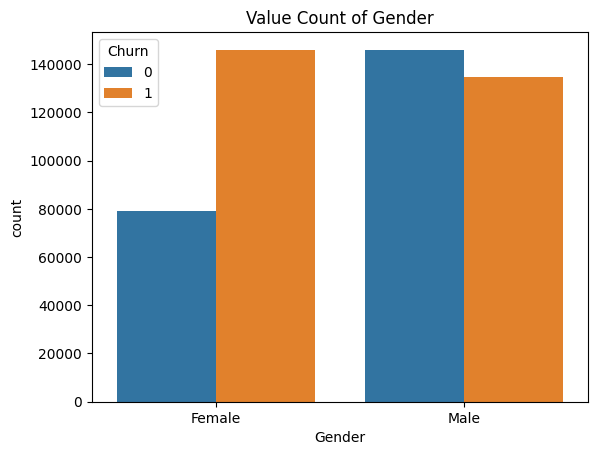

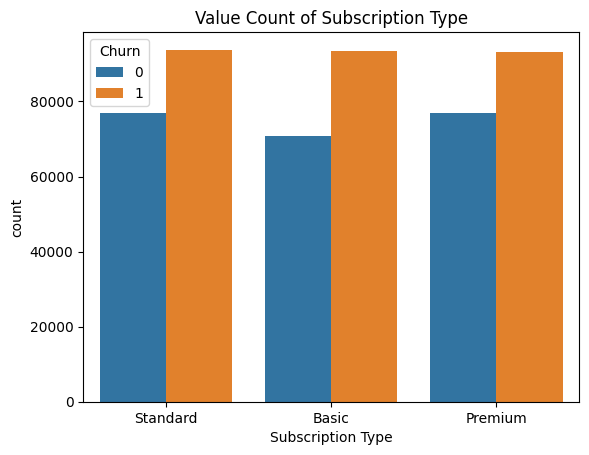

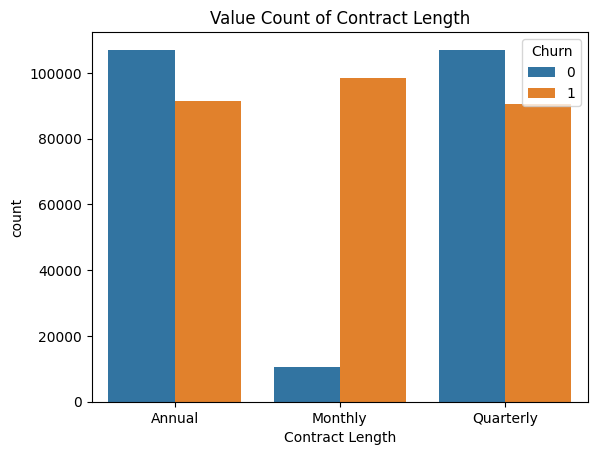

In [6]:
for col in df.columns:
    if df[col].dtypes == "object":
        sns.countplot(x=df[col], hue=df['Churn'])
        plt.title(f"Value Count of {col}")
        print("")
        plt.show()

Females are more likely to churn compared to males.

Customers whose contract length was monthly had the lowest non-churn rate. 

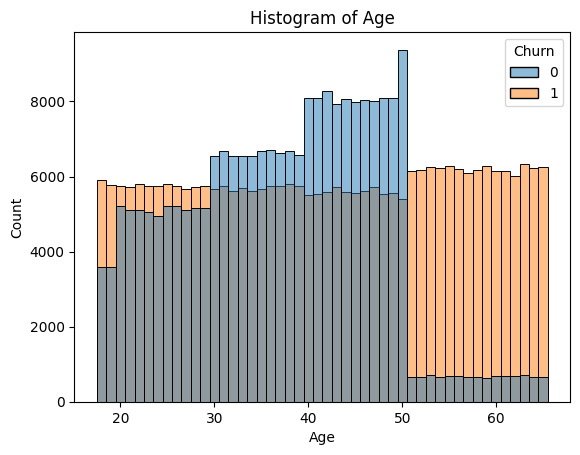

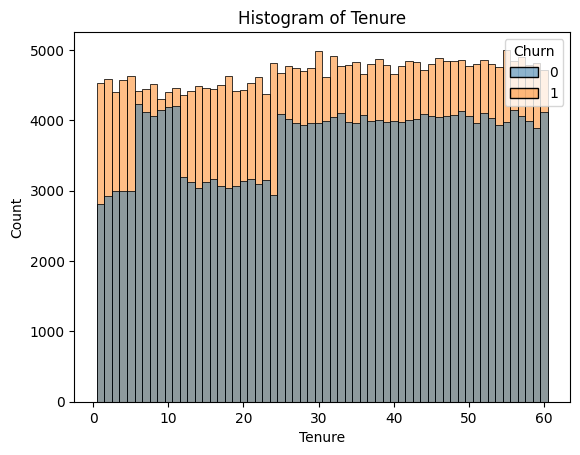

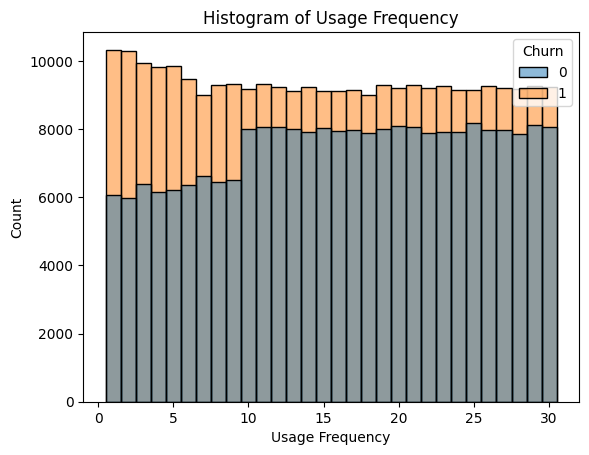

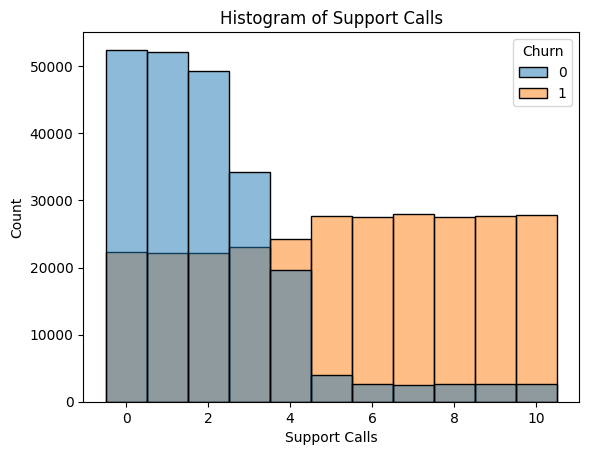

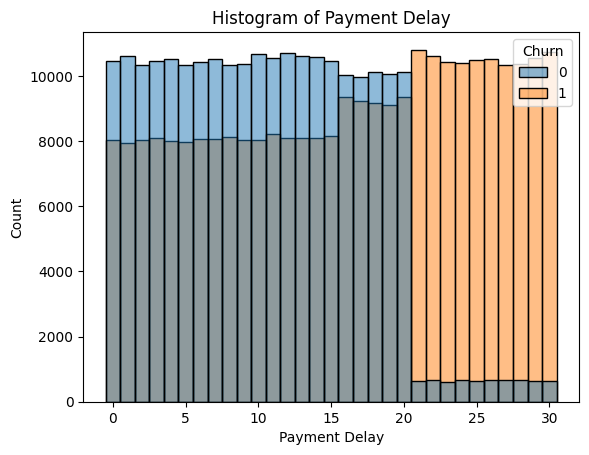

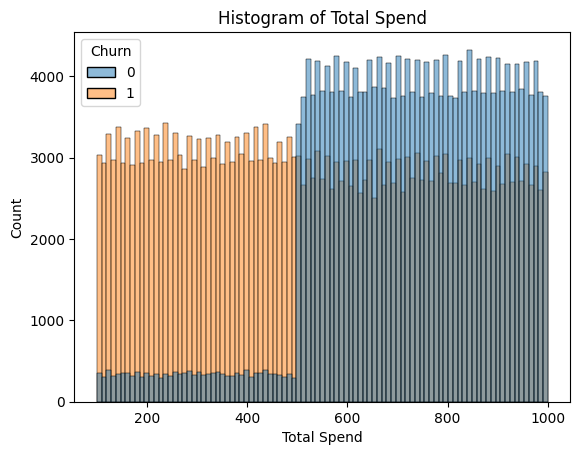

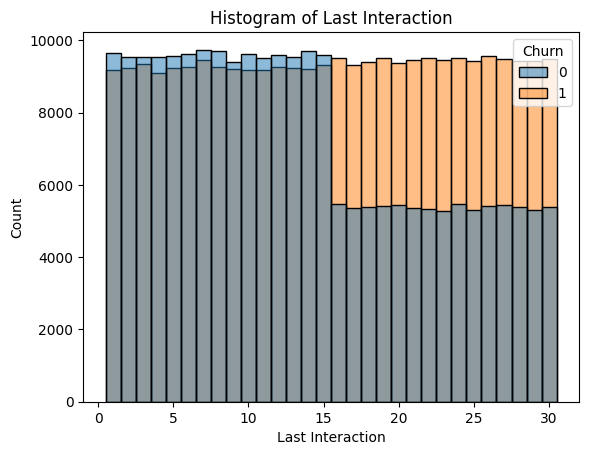

In [17]:
for col in df.columns:
    if col == "Total Spend":
        sns.histplot(x=df[col], hue=df["Churn"])
        plt.title(f"Histogram of {col}")
        plt.show()
    elif df[col].dtype == "int32" and col != "Churn":
        sns.histplot(x=df[col], hue=df["Churn"], discrete=True)
        plt.title(f"Histogram of {col}")
        plt.show()


Customers over 50 years old are more likely to churn.

Higher number of support calls (greater than 4) is strongly associated with increased churn probability.

Frequent payment delays (greater than 20) are strongly associated with an increased likelihood of churn.

Customers whose total spend is below 500 show a significantly higher churn rate.

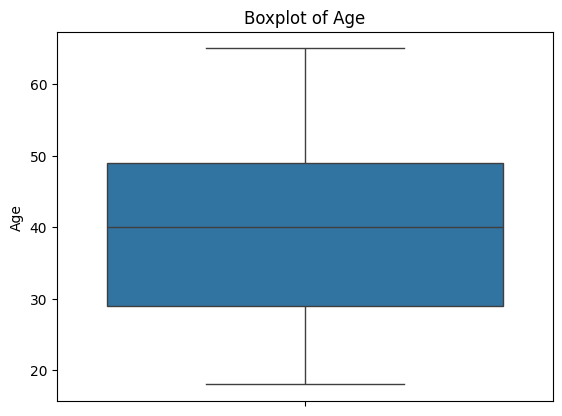

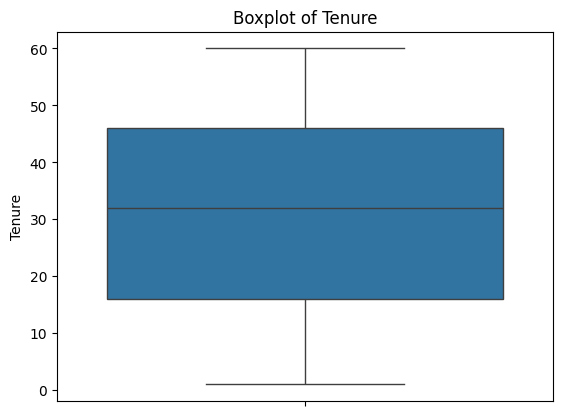

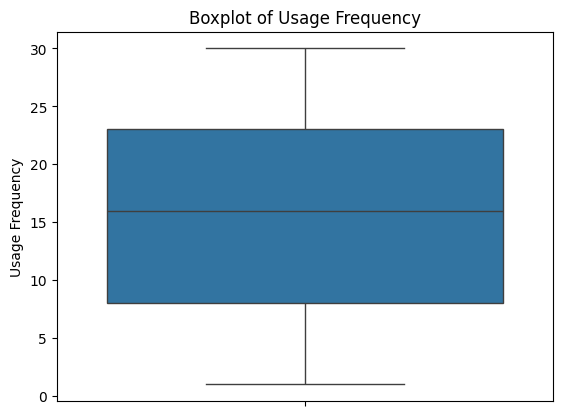

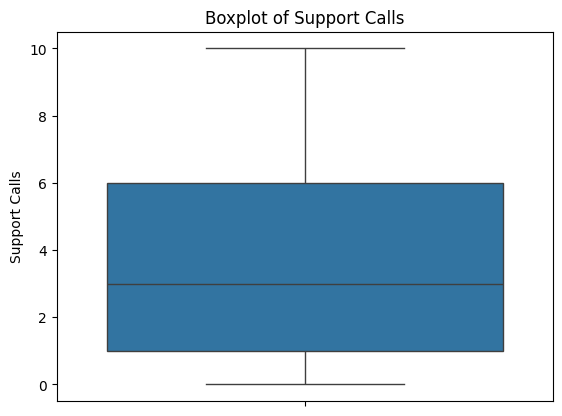

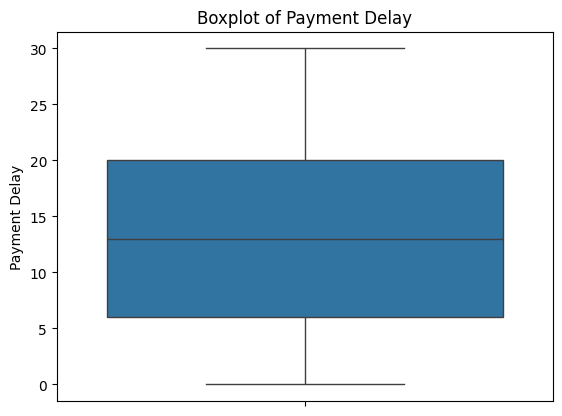

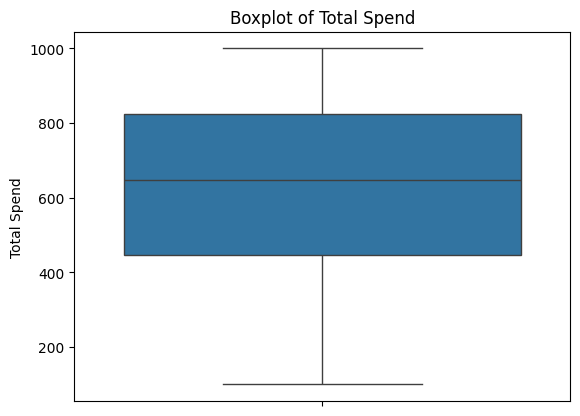

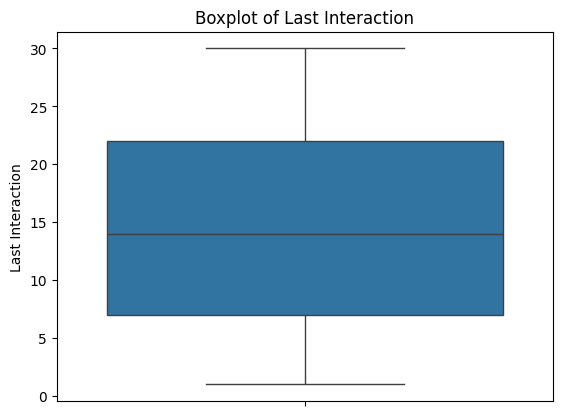

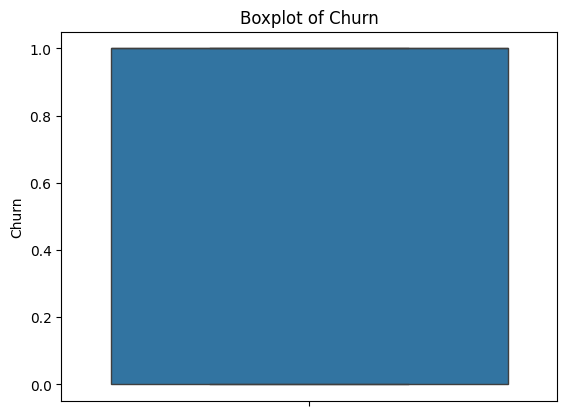

In [ ]:
for col in df.columns:
    if df[col].dtypes == "int32":
        sns.boxplot(df[col])
        plt.title(f"Boxplot of {col}")
        print("")
        plt.show()

There is no outlier in numerical features.

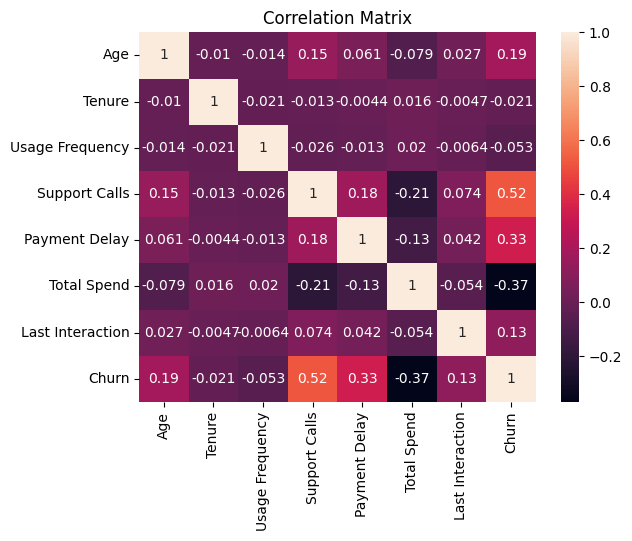

In [ ]:
sns.heatmap(df.select_dtypes(include=['int32', 'float64']).corr(), annot=True)
plt.title("Correlation Matrix")
plt.show()

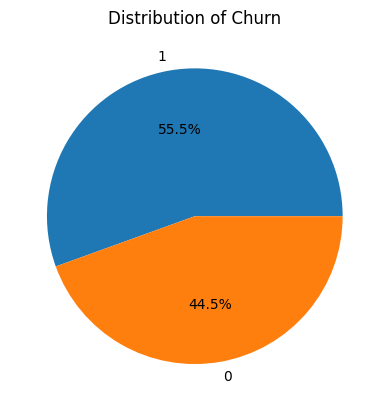

In [ ]:
plt.pie(df["Churn"].value_counts(), labels=df["Churn"].value_counts().index, autopct="%0.1f%%")
plt.title("Distribution of Churn")
plt.show()

Dataset is balanced.

# Prepare Data For Training and Testing

In [26]:
# separate dependent and independent variable
x = df.iloc[:,:-1]
y = df["Churn"]

In [27]:
# split data for training and testing
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

# Model Selection Using Cross Validation Score

In [29]:
# Column Transformer for Pipeline
preprocessor = ColumnTransformer([
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ["Gender"]),
    ("oe", OrdinalEncoder(categories=[["Basic", "Standard", "Premium"], ["Monthly", "Annual", "Quarterly"]]), ["Subscription Type", "Contract Length"])
], remainder="passthrough")

In [ ]:
# check cross validation score for a quick estimate
models = {
    "LogisticRegression" : LogisticRegression(),
    "DecisionTreeClassifier" : DecisionTreeClassifier(),
    "RandomForest" : RandomForestClassifier(),
    "xgboost" : XGBClassifier(),
    "lightgbm" : LGBMClassifier(verbose=-1)
}

# mean accuracy
for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("scaling", StandardScaler()),
        ("model", model)
    ])
    score = cross_val_score(pipe, x, y, cv=3).mean()
    print(f"{name}: {score}")

LogisticRegression: 0.8270269949288013
DecisionTreeClassifier: 0.8698253781625712
RandomForest: 0.9357984663681745
xgboost: 0.9323721412651472


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


lightgbm: 0.9358182602740269


RandomForest, Lightgbm gives higher cross validation score score

# Hyperparameter Tuning of RandomForest

In [10]:
# crate objective function for RandomForest
def objective(trial):
    # Define the hyperparameters to tune
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])

    # Create the RandomForestClassifier model with the suggested hyperparameters
    model = RandomForestClassifier(
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf,
        criterion = criterion,
        random_state = 42,
        n_jobs = -1 # Use all available cores
    )

    # Create a pipeline with preprocessing and the model
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    # Train the model
    pipe.fit(xtrain, ytrain)

    # Make predictions on the test set
    ypre = pipe.predict(xtest)

    # Evaluate the model using accuracy_score
    score = accuracy_score(ytest, ypre)

    return score

In [12]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2025-11-10 09:45:31,279] A new study created in memory with name: no-name-4d1fe075-0852-40c3-ac63-bba29dc484de
[I 2025-11-10 09:48:57,271] Trial 0 finished with value: 0.9175194473585242 and parameters: {'n_estimators': 795, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 11, 'criterion': 'gini'}. Best is trial 0 with value: 0.9175194473585242.
[I 2025-11-10 09:53:15,799] Trial 1 finished with value: 0.9307911561528869 and parameters: {'n_estimators': 581, 'max_depth': 11, 'min_samples_split': 19, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 1 with value: 0.9307911561528869.
[I 2025-11-10 09:57:34,370] Trial 2 finished with value: 0.9278517844064844 and parameters: {'n_estimators': 736, 'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 1 with value: 0.9307911561528869.
[I 2025-11-10 09:57:51,395] Trial 3 finished with value: 0.8854436768868391 and parameters: {'n_estimators': 140, 'max_depth': 2, 'min_sampl

In [13]:
# best parameters of Random Forest with best score
print(f'best accuracy score: {study.best_value}')
print(f'best hyperparameters: {study.best_params}')

best accuracy score: 0.9356208309415887
best hyperparameters: {'n_estimators': 769, 'max_depth': 26, 'min_samples_split': 14, 'min_samples_leaf': 10, 'criterion': 'entropy'}


## Train RandomForest Pipeline

In [16]:
# create RandomForest model with hyperparameters
rf_model = RandomForestClassifier(
        n_estimators = 769,
        max_depth = 26,
        min_samples_split = 14,
        min_samples_leaf = 10,
        criterion = "entropy",
        random_state = 42,
    )

# Create a pipeline with preprocessing and the model
rf_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", rf_model)
])

In [17]:
# Train the pipeline
rf_pipe.fit(xtrain, ytrain)

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender']),
                                                 ('oe',
                                                  OrdinalEncoder(categories=[['Basic',
                                                                              'Standard',
                                                                              'Premium'],
                                                                             ['Monthly',
                                                                              'Annual',
                                                                              'Quarterly']]),
                                                  ['Subscription Type',
                                                   'Contract Length'])])),
                ('model',
                 RandomForestClassifier(criterion='entropy', max_depth=26,
                                        min_samples_leaf=10,
                                        min_samples_split=14, n_estimators=769,
                                        random_state=42))])

## Feature Importance of RandomForest Pipeline

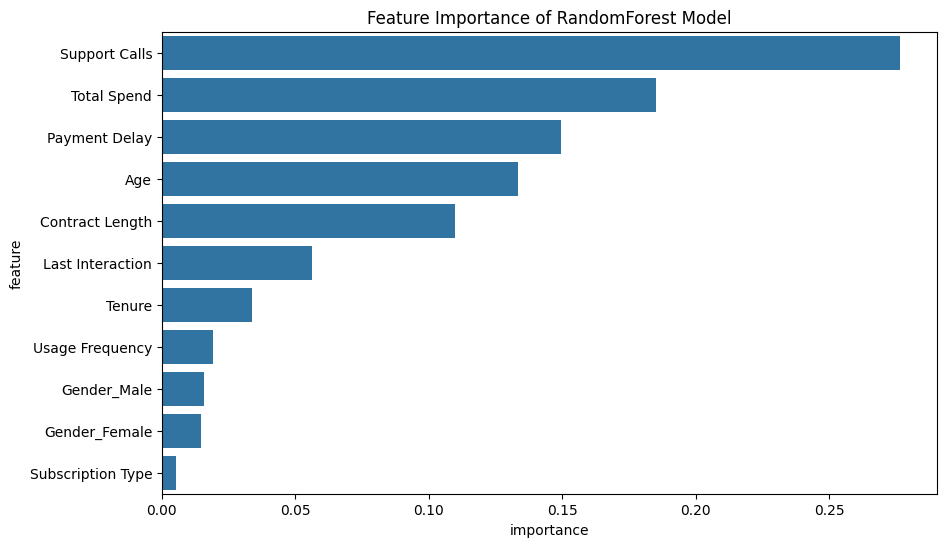

In [19]:
# Get feature importances from the trained RandomForest model
feature_importances = rf_pipe.named_steps['model'].feature_importances_

# Get feature names after preprocessing
ohe_feature_names = rf_pipe.named_steps['preprocessor'].named_transformers_['ohe'].get_feature_names_out(['Gender'])
oe_feature_names = ['Subscription Type', 'Contract Length']

# Get the names of the remaining columns (passthrough)
input_features = list(xtrain.columns)
transformed_features = list(ohe_feature_names) + list(oe_feature_names)
remaining_feature_names = [f for f in input_features if f not in ['Gender', 'Subscription Type', 'Contract Length']]


# Combine all feature names
all_feature_names = list(ohe_feature_names) + list(oe_feature_names) + list(remaining_feature_names)

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': feature_importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance of RandomForest Model')
plt.show()

## Hyperparameter Tuning Of LightGBM

In [33]:
# create objective function for LightGBM
def objective(trial):
    # Define the hyperparameters to tune for LightGBM
    n_estimators = trial.suggest_int('n_estimators', 100, 1000),
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    max_depth = trial.suggest_int('max_depth', 3, 15),
    min_child_samples = trial.suggest_int('min_child_samples', 1, 20),
    subsample = trial.suggest_float('subsample', 0.6, 1.0),
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)

    # Create the LGBMClassifier model with the suggested hyperparameters
    model = LGBMClassifier(
        objective = 'binary',  # For binary classification
        metric = 'binary_accuracy',
        n_estimators = n_estimators,
        learning_rate = learning_rate,
        num_leaves = num_leaves,
        max_depth = max_depth,
        min_child_samples = min_child_samples,
        subsample = subsample,
        colsample_bytree = colsample_bytree,
        random_state = 42,
        n_jobs = -1,
        verbose = -1 # Suppress verbose output during tuning
    )

    # Create a pipeline with preprocessing and the model
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    # Train the model
    pipe.fit(xtrain, ytrain)

    # Make predictions on the test set
    ypre = pipe.predict(xtest)

    # Evaluate the model using accuracy_score
    score = accuracy_score(ytest, ypre)

    return score

In [31]:
# Create an Optuna study and optimize the objective function
study_lgbm = optuna.create_study(direction="maximize")
study_lgbm.optimize(objective, n_trials=30)

[I 2025-11-10 13:12:25,889] A new study created in memory with name: no-name-1eda21a4-d35e-4c8e-beee-390967c00215
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-10 13:12:57,746] Trial 0 finished with value: 0.9337800122721245 and parameters: {'n_estimators': 707, 'learning_rate': 0.19177039345644595, 'num_leaves': 82, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.8446072513368135, 'colsample_bytree': 0.9741932175046921}. Best is trial 0 with value: 0.9337800122721245.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-10 13:13:58,134] Trial 1 finished with value: 0.9338294966449595 and parameters: {'n_estimators': 916, 'learning_rate': 0.030835844478415655, 'num_leaves': 95, 'm

In [32]:
# best parameters of LightGBM with best score
print(f'best accuracy score: {study_lgbm.best_value}')
print(f'best hyperparameters: {study_lgbm.best_params}')

best accuracy score: 0.9358682528057639
best hyperparameters: {'n_estimators': 293, 'learning_rate': 0.0803002916712067, 'num_leaves': 115, 'max_depth': 15, 'min_child_samples': 3, 'subsample': 0.6516486468886507, 'colsample_bytree': 0.8778447325834215}


## Train LightGBM Pipeline

In [40]:
# create LightGBM model with hyperparameters
lgbm_model = LGBMClassifier(
    objective = 'binary',  # For binary classification
    metric = 'binary_accuracy',
    n_estimators = 293,
    learning_rate = 0.0803002916712067,
    num_leaves = 115,
    max_depth = 15,
    min_child_samples = 3,
    subsample = 0.6516486468886507,
    colsample_bytree = 0.8778447325834215,
    random_state = 42,
    verbose = -1
)

# Create a pipeline with preprocessing and the model
lgbm_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", lgbm_model)
])

In [41]:
# Train the pipeline
lgbm_pipe.fit(xtrain, ytrain)

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender']),
                                                 ('oe',
                                                  OrdinalEncoder(categories=[['Basic',
                                                                              'Standard',
                                                                              'Premium'],
                                                                             ['Monthly',
                                                                              'Annual',
                                                                              'Quarterly']]),
                                                  ['Subscription Type',
                                                   'Contract Length'])])),
                ('model',
                 LGBMClassifier(colsample_bytree=0.8778447325834215,
                                learning_rate=0.0803002916712067, max_depth=15,
                                metric='binary_accuracy', min_child_samples=3,
                                n_estimators=293, num_leaves=115,
                                objective='binary', random_state=42,
                                subsample=0.6516486468886507, verbose=-1))])

## Feature Importance of LightGBM Pipeline

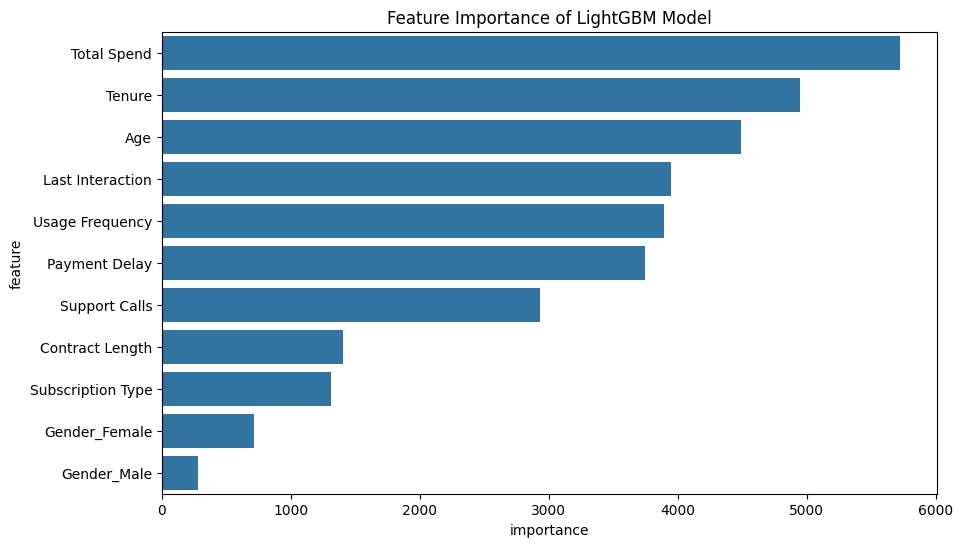

In [42]:
# Get feature importances from the trained LightGBM model
feature_importances_lgbm = lgbm_pipe.named_steps['model'].feature_importances_

# Get feature names after preprocessing (same as for RandomForest)
ohe_feature_names = lgbm_pipe.named_steps['preprocessor'].named_transformers_['ohe'].get_feature_names_out(['Gender'])
oe_feature_names = ['Subscription Type', 'Contract Length']
input_features = list(xtrain.columns)
transformed_features = list(ohe_feature_names) + list(oe_feature_names)
remaining_feature_names = [f for f in input_features if f not in ['Gender', 'Subscription Type', 'Contract Length']]
all_feature_names_lgbm = list(ohe_feature_names) + list(oe_feature_names) + list(remaining_feature_names)

# Create a DataFrame for better visualization
feature_importance_df_lgbm = pd.DataFrame({'feature': all_feature_names_lgbm, 'importance': feature_importances_lgbm})

# Sort by importance
feature_importance_df_lgbm = feature_importance_df_lgbm.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df_lgbm)
plt.title('Feature Importance of LightGBM Model')
plt.show()

## Evaluation

In [44]:
# Make predictions on the test set for both models
y_pred_rf = rf_pipe.predict(xtest)
y_pred_lgbm = lgbm_pipe.predict(xtest)

# Print classification report for RandomForest
print("Classification Report for RandomForest:")
print(classification_report(ytest, y_pred_rf))

# Print classification report for LightGBM
print("\nClassification Report for LightGBM:")
print(classification_report(ytest, y_pred_lgbm))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     45086
           1       0.90      1.00      0.94     55956

    accuracy                           0.94    101042
   macro avg       0.95      0.93      0.93    101042
weighted avg       0.94      0.94      0.93    101042


Classification Report for LightGBM:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     45086
           1       0.90      1.00      0.95     55956

    accuracy                           0.94    101042
   macro avg       0.95      0.93      0.93    101042
weighted avg       0.94      0.94      0.94    101042



## Result :- Based on the classification reports above, both the RandomForest and LightGBM models demonstrate comparable performance in predicting customer churn. The accuracy, precision, recall, and f1-scores are very similar for both models.